In [44]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2

In [45]:
labels = os.listdir("../input/drowsiness-dataset/train")

In [47]:
labels

['Closed', 'Open', 'yawn', 'no_yawn']

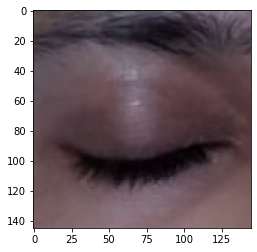

In [48]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread("../input/drowsiness-dataset/train/Closed/_0.jpg"))

In [52]:
a = plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg")

In [54]:
a.shape

(480, 640, 3)

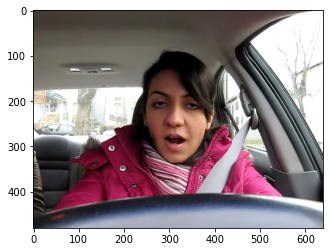

In [56]:
plt.imshow(plt.imread("../input/drowsiness-dataset/train/yawn/10.jpg"))

In [ ]:
def face_for_yawn(direc="../input/drowsiness-dataset/train", face_cas_path="../input/prediction-images/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

In [ ]:
def get_data(dir_path="../input/drowsiness-dataset/train/", face_cas="../input/prediction-images/haarcascade_frontalface_default.xml", eye_cas="../input/prediction-images/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [59]:
data_train = get_data()

2
3


In [61]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [62]:
new_data = append_data()

0
1
2
3


In [66]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [68]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [73]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [78]:
y = np.array(y)

In [81]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [83]:
len(X_test)

578

In [86]:
# !pip install tensorflow==2.3.1
# !pip install keras==2.4.3

In [89]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [91]:
tf.__version__

'2.3.0'

In [93]:
import keras
keras.__version__

'2.4.3'

In [95]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [98]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 14, 14, 32)       

In [99]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 191s 4s/step - loss: 0.9837 - accuracy: 0.5694 - val_loss: 0.5003 - val_accuracy: 0.7699
Epoch 2/50
43/43 [==============================] - 191s 4s/step - loss: 0.5284 - accuracy: 0.7944 - val_loss: 0.3761 - val_accuracy: 0.8668
Epoch 3/50
43/43 [==============================] - 190s 4s/step - loss: 0.3716 - accuracy: 0.8500 - val_loss: 0.3499 - val_accuracy: 0.8633
Epoch 4/50
43/43 [==============================] - 190s 4s/step - loss: 0.3485 - accuracy: 0.8560 - val_loss: 0.2477 - val_accuracy: 0.9066
Epoch 5/50
43/43 [==============================] - 190s 4s/step - loss: 0.2673 - accuracy: 0.8886 - val_loss: 0.2263 - val_accuracy: 0.9118
Epoch 6/50
43/43 [==============================] - 190s 4s/step - loss: 0.2941 - accuracy: 0.8768 - val_loss: 0.2232 - val_accuracy: 0.9152
Epoch 7/50
43/43 [==============================] - 189s 4s/step - loss: 0.2527 - accuracy: 0.8968 - val_loss: 0.1926 - val_accuracy: 0.9360
Epoch 8/50
43

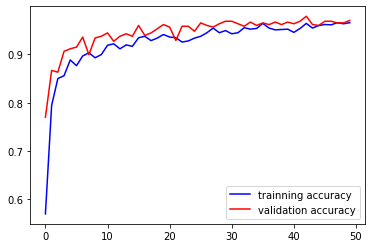

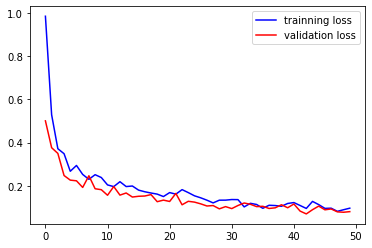

In [115]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [119]:
model.save("drowsiness.h5")

In [120]:
model.save("drowsiness.model")

In [121]:
prediction = model.predict_classes(X_test)

In [122]:
prediction

array([3, 3, 2, 3, 1, 3, 3, 2, 1, 2, 3, 3, 3, 2, 2, 2, 3, 0, 0, 2, 3, 3,
       2, 1, 0, 2, 2, 2, 3, 2, 3, 2, 3, 2, 0, 3, 3, 2, 0, 2, 3, 3, 2, 3,
       2, 2, 3, 3, 2, 3, 3, 1, 2, 1, 2, 3, 2, 2, 2, 0, 3, 3, 1, 2, 2, 3,
       2, 3, 2, 2, 1, 3, 3, 3, 2, 0, 0, 3, 1, 3, 2, 1, 3, 2, 2, 2, 2, 0,
       3, 3, 2, 3, 3, 3, 1, 0, 3, 0, 3, 3, 3, 1, 3, 1, 2, 3, 2, 1, 2, 2,
       0, 1, 2, 1, 0, 3, 3, 3, 2, 2, 3, 3, 3, 1, 1, 2, 3, 2, 2, 1, 3, 3,
       1, 3, 1, 2, 2, 3, 2, 1, 2, 2, 2, 1, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3,
       2, 0, 1, 0, 3, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 3, 1, 2, 0, 3, 2,
       2, 2, 0, 2, 3, 0, 2, 0, 3, 0, 3, 1, 2, 0, 1, 3, 2, 1, 3, 2, 3, 0,
       3, 2, 3, 0, 2, 0, 0, 1, 2, 3, 2, 0, 3, 0, 2, 2, 2, 2, 1, 3, 1, 1,
       1, 0, 0, 2, 3, 3, 3, 0, 1, 2, 0, 0, 3, 3, 1, 3, 3, 0, 3, 3, 1, 0,
       0, 0, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 2, 0, 2, 2, 2, 0, 3, 3, 2, 2,
       3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 0, 3, 3, 3, 3, 2,
       2, 0, 2, 2, 0, 3, 2, 0, 2, 2, 1, 3, 2, 3, 1,

In [126]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [127]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), prediction, target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.81      0.90      0.86        63
     no_yawn       0.87      0.89      0.88        74
      Closed       0.93      0.95      0.94       215
        Open       0.99      0.93      0.96       226

    accuracy                           0.93       578
   macro avg       0.90      0.92      0.91       578
weighted avg       0.93      0.93      0.93       578



In [129]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new6.h5")

In [130]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("../input/drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

In [131]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Closed/_101.jpg")])
np.argmax(prediction)

2

In [132]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
np.argmax(prediction)

3

In [133]:
prediction = model.predict([prepare("../input/drowsiness-dataset/train/yawn/113.jpg")])
np.argmax(prediction)

3